# Calibrate Cameras
[https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp](https://github.com/jayrambhia/Vision/blob/master/OpenCV/C%2B%2B/stereocalibrate.cpp)

In [12]:
from models.dataset.dataset_container import DatasetContainer
from models.calibration.calibration import StereoCalibration
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

In [22]:
resource_path = Path("../../resources")

class Args:
    uncalibrated_dataset_path = resource_path / Path("images/uncalibrated/dataset_3.npz")
    calibration_file_path = resource_path / Path("calibrations/dataset_3.yml")
    common_points_threshold = 50
    alpha = -1 # 0 => calibrated images wont contain 'black' spaces, 1 => no pixels lost, -1 => auto
    save = False
args = Args()

## Actual Calibration

In [23]:
dataset_container = DatasetContainer()
dataset_container.load_from_dataset(args.uncalibrated_dataset_path)

print(f"Opened dataset containing {dataset_container.size()} image sets")

# charuco board configuration
charuco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50) 
charuco_board = cv2.aruco.CharucoBoard_create(7, 5, 7.5, 5.625, charuco_dict)

# get extrinsic transformation between both cameras
calibration = StereoCalibration()
calibration.configure_from_dataset(
    charuco_dict=charuco_dict, 
    charuco_board=charuco_board, 
    dataset_container=dataset_container,
    common_points_threshold=args.common_points_threshold, 
    alpha=args.alpha,
    silent=False
)

# save calibration result
if args.save:
    calibration.save_calibration(args.calibration_file_path)


Opened dataset containing 16 image sets
R
[[ 0.93042489  0.03953516 -0.36434392]
 [-0.04823611  0.99872619 -0.0148082 ]
 [ 0.36329437  0.03135245  0.93114673]]
T
[[17.60399072]
 [ 5.07979225]
 [15.92657604]]


## Visualize

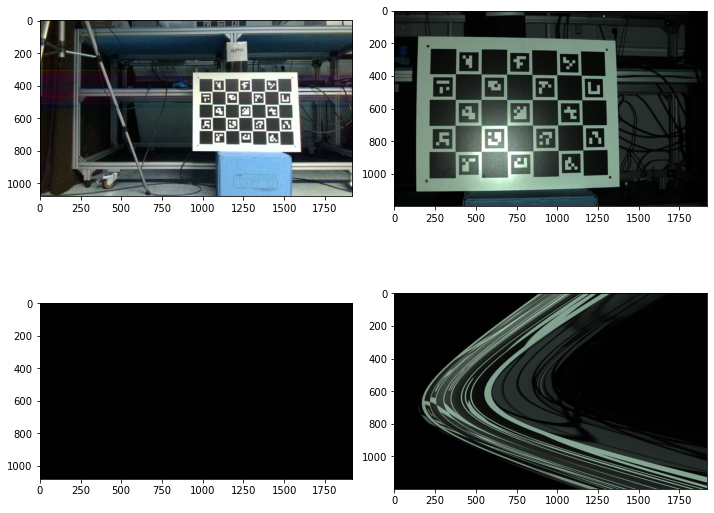

In [24]:
# visualize calibration result
idx = 2
img1, _, img2, _ = dataset_container[idx]
imgU1, imgU2 = calibration.remap(img1, img2)

f, axarr = plt.subplots(2, 2, figsize=(10, 8))
f.tight_layout()
axarr[0][0].imshow(img1)
axarr[0][1].imshow(img2)
axarr[1][0].imshow(imgU1)
axarr[1][1].imshow(imgU2)